I got a question about interpreting plots you get from [Arviz](https://arviz-devs.github.io/). This particular one was about LOO-PIT which you can find [here](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_loo_pit.html).

Let's go into more details about why you ever need this plot, how to work with it and which actions to take after you see it. A case study.

## A generative model

First of all, we need a model to demonstrate the pathologies that can be diagnosed with the LOO-PIT. I will use linear regression with robust likelihood to show all possible cases that can be fixed just by looking at the plot.

But wait, what is LOO-PIT is you ask? Ok, let's give some theory before we start.

* LOO stays for Leave One Out validation. We usually want LOO to cross-validate our model. We train it on all but the one observarions and then make predictions on the one that was holdout. We do that for every single observation.
* PIT stays for Probability Integral Transformation. Briefly, it transforms any continuous distribution to the Uniform distribution.

While it is relatively clear what is LOO, it is not super clear, what is PIT. Let's make some visualizations.

In [86]:
import scipy.stats
import matplotlib.pyplot as plt
import arviz as az
import numpy as np
import warnings
az.style.use("arviz-white")
warnings.filterwarnings("ignore")

In [101]:
student_t = scipy.stats.t(df=5)
uniform = scipy.stats.uniform()

In [104]:
t = student_t.rvs(size=10000)
u = student_t.cdf(x)

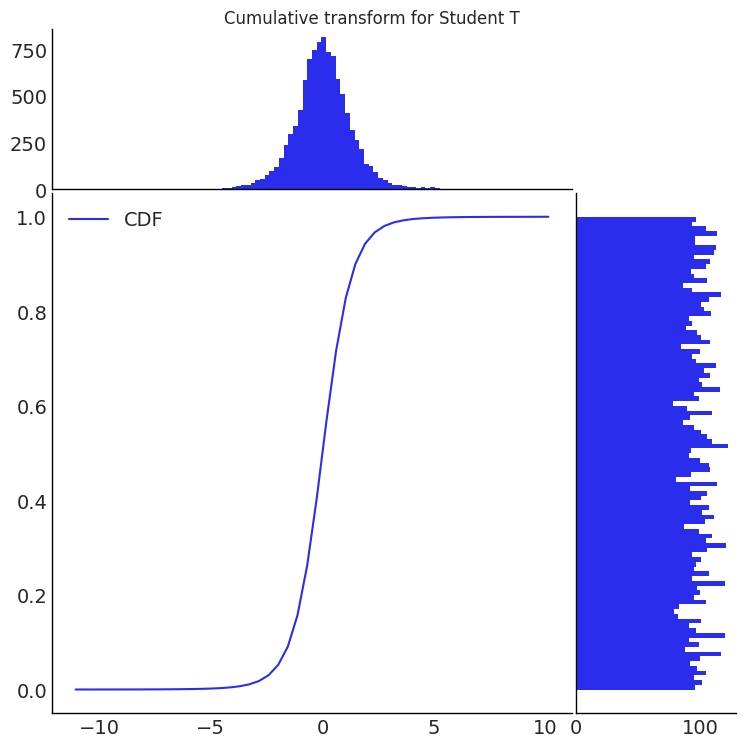

In [102]:
def scatter_hist(dist1, dist2, ax, ax_histx, ax_histy, n=10000):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    np.random.seed(50)
    x = dist1.rvs(size=n)
    y = dist1.cdf(x)
    r = np.linspace(min(x), max(x))
    ax.plot(r, dist1.cdf(r), label="CDF")
    ax_histx.hist(x, bins=100)
    ax_histy.hist(y, bins=100, orientation='horizontal')

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

scatter_hist(student_t, uniform, ax, ax_histx, ax_histy);
ax.legend()
plt.suptitle("Cumulative transform for Student T");

We see that the cumulative transform does the job and transforms our StudentT random variables to the Uniform distribution. Similar ideas are used for LOO-PIT.

1. [Compute](https://github.com/arviz-devs/arviz/blob/9d0746972c9bcb1a3063c0ca00ff08a0b0c093ee/arviz/stats/stats.py#L1674) pointwise likelihood for all the observations
2. [Calcutale](https://github.com/arviz-devs/arviz/blob/9d0746972c9bcb1a3063c0ca00ff08a0b0c093ee/arviz/stats/stats.py#L770) LOO likelihood approximation using [pareto smoothed importance sampling](https://arxiv.org/abs/1507.02646)
3. [Approximate](https://github.com/arviz-devs/arviz/blob/9d0746972c9bcb1a3063c0ca00ff08a0b0c093ee/arviz/stats/stats.py#L1729) inverse CDF values of the posterior predictive (for each sample)
4. [Approximate](https://github.com/arviz-devs/arviz/blob/9d0746972c9bcb1a3063c0ca00ff08a0b0c093ee/arviz/plots/loopitplot.py#L177) the i-CDF function for visualization with KDE

If the likelihood is well specified, we'll see a uniform distribution of i-CDF values, means, uniform KDE